# Prior Correlation Structure under Perturbations

In [2]:
import argparse
import os, sys
import time
import tabulate

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as trn
import numpy as np
import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from swag import data, models, utils, losses
from swag.posteriors import SWAG

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
import ctypes
from wand.api import library as wandlibrary

wandlibrary.MagickMotionBlurImage.argtypes = (ctypes.c_void_p,  # wand
                                              ctypes.c_double,  # radius
                                              ctypes.c_double,  # sigma
                                              ctypes.c_double)  # angle

In [4]:
from ubdl_data.corruptions import gaussian_noise, shot_noise, impulse_noise, defocus_blur, glass_blur, motion_blur
from ubdl_data.corruptions import zoom_blur, snow, frost, fog , brightness, contrast, elastic_transform, pixelate
from ubdl_data.corruptions import jpeg_compression, speckle_noise, gaussian_blur, spatter, saturate

In [5]:
import collections

d = collections.OrderedDict()
d['Gaussian Noise'] = gaussian_noise
d['Shot Noise'] = shot_noise
d['Impulse Noise'] = impulse_noise
d['Defocus Blur'] = defocus_blur
d['Glass Blur'] = glass_blur
d['Motion Blur'] = motion_blur
d['Zoom Blur'] = zoom_blur
d['Snow'] = snow
d['Frost'] = frost
d['Fog'] = fog
d['Brightness'] = brightness
d['Contrast'] = contrast
d['Elastic'] = elastic_transform
d['Pixelate'] = pixelate
d['JPEG'] = jpeg_compression

d['Speckle Noise'] = speckle_noise 
d['Gaussian Blur'] = gaussian_blur
d['Spatter'] = spatter 
d['Saturate'] = saturate


In [6]:
model_cfg = models.PreResNet20NoAug

test_data = torchvision.datasets.CIFAR10("~/datasets/cifar10", train=False)
convert_img = trn.Compose([trn.ToTensor(), trn.ToPILImage()])

model = model_cfg.base(*model_cfg.args, num_classes=10, **model_cfg.kwargs)
model.cuda();

In [7]:
def resample(model, sigma=1):
    for p in model.parameters():
        p.copy_(torch.randn_like(p) * sigma)
        
def softmax(arr, axis=-1):
    arr_ = arr - np.max(arr, axis=axis, keepdims=True)
    return np.exp(arr_) / np.sum(np.exp(arr_), axis=axis, keepdims=True)

## Test Data

In [8]:
y = np.array(test_data.targets)
x = test_data.data

mask = np.zeros_like(y).astype(bool)
classes = list(range(10))
perclass = 10

for cls in classes:
    mask_cls = np.where(y == cls)[0]
    mask[mask_cls[5:5+perclass]] = True

x = x[mask]
y = y[mask]

idx = np.argsort(y)
x = x[idx]
y = y[idx]

## Functions Evaluating Correlation
Functions evaluating correlations between different images and between different corruptions of the same image.

In [9]:
def iic_correlations(outputs, y):
    # i -- image + distortion
    # c -- channel
    # s -- weight sample

    n_classes, perclass = outputs.shape[:2]

    all_outputs_ics =  outputs.reshape((-1, *all_outputs.shape[2:]))

    all_outputs_mean_ic = all_outputs_ics.mean(axis=-1)
    all_outputs_zeromean_ics = (all_outputs_ics - all_outputs_mean_ic[:, :, None])
    all_outputs_cov_iic = np.einsum('ics,jcs->ijc', all_outputs_zeromean_ics, all_outputs_zeromean_ics)
    all_outputs_vars_ic = np.einsum('ics,ics->ic', all_outputs_zeromean_ics, all_outputs_zeromean_ics)
    all_outputs_sqrt_ic = np.sqrt(all_outputs_vars_ic)
    all_outputs_corr_iic = all_outputs_cov_iic / all_outputs_sqrt_ic[:, None] / all_outputs_sqrt_ic[None, :]

    avg_corrs = np.zeros((n_classes, n_classes))
    for i, cls_x in enumerate(range(n_classes)):
        for j, cls_y in enumerate(range(n_classes)):
            mask = (y==cls_x).astype(int)[:, None] * (y==cls_y).astype(int)[None, :] 
            avg_corrs[i, j] = (all_outputs_corr_iic[:, :, 0] * mask).sum() / mask.sum()
    return all_outputs_corr_iic, avg_corrs

In [10]:
def iddc_correlations(outputs):
    # i -- image
    # d -- disctortion (corruption) severisy
    # c -- channel
    # s -- weight sample

    all_outputs_idcs =  outputs

    all_outputs_mean_idc = all_outputs_idcs.mean(axis=-1)
    all_outputs_zeromean_idcs = (all_outputs_idcs - all_outputs_mean_idc[:, :, :, None])
    all_outputs_cov_iddc = np.einsum('idcs,ibcs->idbc', all_outputs_zeromean_idcs, all_outputs_zeromean_idcs)
    all_outputs_vars_idc = np.einsum('idcs,idcs->idc', all_outputs_zeromean_idcs, all_outputs_zeromean_idcs)
    all_outputs_sqrt_idc = np.sqrt(all_outputs_vars_idc)
    all_outputs_corr_iddc = all_outputs_cov_iddc / all_outputs_sqrt_idc[:, :, None] / all_outputs_sqrt_idc[:, None, :]
    return all_outputs_corr_iddc

## Applying Corruption

Uncomment one of the corruptions.

In [11]:
# corruption_name = 'Gaussian Noise'
# corruption_name = 'Shot Noise'
# corruption_name = 'Impulse Noise'
# corruption_name = 'Defocus Blur'
# corruption_name = 'Glass Blur'
# corruption_name = 'Motion Blur'
# corruption_name = 'Zoom Blur'
# corruption_name = 'Snow'
# corruption_name = 'Frost'
# corruption_name = 'Fog'
# corruption_name = 'Brightness'
# corruption_name = 'Contrast'
# corruption_name = 'Elastic'
# corruption_name = 'Pixelate'
# corruption_name = 'JPEG'
# corruption_name = 'Speckle Noise'
# corruption_name = 'Gaussian Blur'
# corruption_name = 'Spatter'
# corruption_name = 'Saturate'
corruption_name = 'Translation'

corruption = lambda img, intensity: np.array(trn.RandomCrop(32, padding=2*intensity)(img))


In [12]:
corrupted_imgs = []
corrupted_y = []

for idx, img in enumerate(x):
    img = convert_img(img)
    this_corrupted_imgs = [np.array(img)[None, :]]
    corrupted_y.append(idx)
    
    for intensity in range(1,6):
        corrupted_img = corruption(img, intensity)
        this_corrupted_imgs.append(corrupted_img[None, :])
        corrupted_y.append(idx)
    corrupted_imgs.append(np.vstack(this_corrupted_imgs)[None, :])
corrupted_imgs = np.vstack(corrupted_imgs)
corrupted_y = np.array(corrupted_y)

### Examples

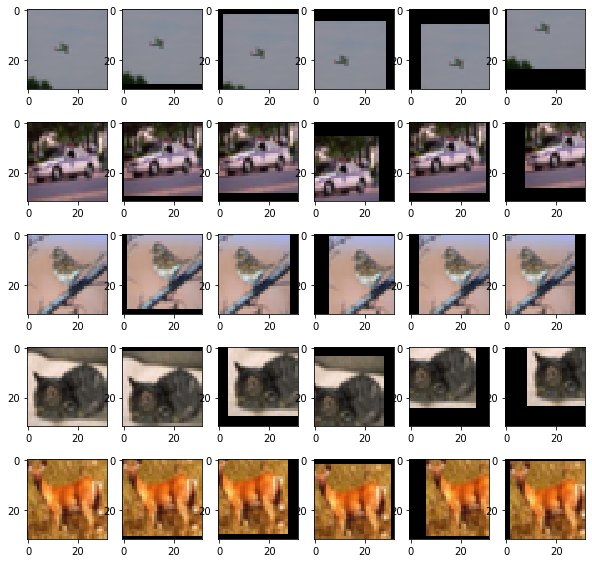

In [13]:
f, arr = plt.subplots(5, 6, figsize = (10, 10))
for i in range(5):
    for j in range(len(corrupted_imgs[0])):
        arr[i, j].imshow(corrupted_imgs[i*perclass][j] / 255.)

## PreResNet-20 Correlations

In [14]:
x_test =  corrupted_imgs.reshape((-1, 32, 32, 3)).transpose(0,3,1,2)
x_test = torch.from_numpy(x_test).float().cuda()

In [15]:
all_outputs = []
sigma = 1.

model = model_cfg.base(*model_cfg.args, num_classes=10, **model_cfg.kwargs).cuda();
with torch.no_grad():
    for i in range(100):
        resample(model, sigma=sigma)
        outputs = model(x_test).data.cpu().numpy()[:, :, None]
        all_outputs.append(outputs.reshape(-1, 6, 10, 1))
    all_outputs = np.concatenate(all_outputs, axis=-1)

In [16]:
all_outputs_corr_iic, avg_corrs = iic_correlations(all_outputs[:, 0], np.arange(all_outputs.shape[0]))
print("Mean Original IMG corr:", all_outputs_corr_iic[:, :, 0].mean())

Mean Original IMG corr: 0.9023127


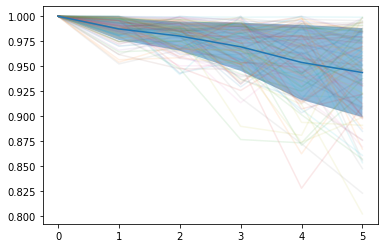

In [17]:
all_outputs_corr_iddc = iddc_correlations(all_outputs)

corr_mean = all_outputs_corr_iddc.mean(axis=0)
corr_std = all_outputs_corr_iddc.std(axis=0)

plt.plot(all_outputs_corr_iddc[:, 0, :, 0].T, alpha=0.1)
plt.plot(corr_mean[0, :, 0])
plt.fill_between(range(6), 
                 corr_mean[0, :, 0] - corr_std[0, :, 0], 
                 corr_mean[0, :, 0] + corr_std[0, :, 0], alpha=0.5)



In [18]:
np.save("{}_resnet".format(corruption_name),
       all_outputs_corr_iddc[:, 0, :, 0]
       )

## Linear Model Correlations

In [19]:
x_test_ = x_test.reshape((x_test.shape[0], -1))

In [20]:
all_outputs = []
sigma = .3

x_test

with torch.no_grad():
    for i in range(100):
        model = torch.nn.Sequential(torch.nn.Linear(x_test_.shape[1], 1)).cuda()
        resample(model, sigma=sigma)
        outputs = model(x_test_).data.cpu().numpy()[:, :, None]
        all_outputs.append(outputs.reshape(-1, 6, 1, 1))
    all_outputs = np.concatenate(all_outputs, axis=-1)

In [21]:
all_outputs_corr_iic, avg_corrs = iic_correlations(all_outputs[:, 0], np.arange(all_outputs.shape[0]))
print("Mean Original IMG corr:", all_outputs_corr_iic[:, :, 0].mean())

Mean Original IMG corr: 0.838491


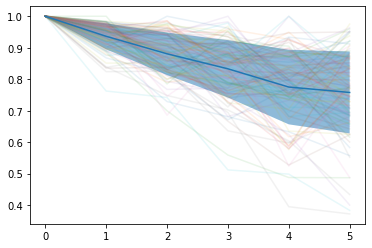

In [22]:
all_outputs_corr_iddc = iddc_correlations(all_outputs)

corr_mean = all_outputs_corr_iddc.mean(axis=0)
corr_std = all_outputs_corr_iddc.std(axis=0)

plt.plot(all_outputs_corr_iddc[:, 0, :, 0].T, alpha=0.1)
plt.plot(corr_mean[0, :, 0])
plt.fill_between(range(6), 
                 corr_mean[0, :, 0] - corr_std[0, :, 0], 
                 corr_mean[0, :, 0] + corr_std[0, :, 0], alpha=0.5)



In [23]:
np.save("{}_linear".format(corruption_name),
       all_outputs_corr_iddc[:, 0, :, 0]
       )

## RBF kernel

In [24]:
from scipy.spatial.distance import cdist

In [25]:
def rbf_cov(x, l=15e3):
    dists = cdist(x, x)
    covs = np.exp(-dists**2 / l**2)
    return covs

In [26]:
x_test_ = x_test.cpu().numpy().reshape((-1, 6, 3, 32, 32))
x_test_ = x_test_.reshape((*x_test_.shape[:2], -1))

In [27]:
covs = rbf_cov(x_test_[:, 0])
print("Mean Original IMG corr:", covs.mean())

Mean Original IMG corr: 0.8916203176690131


In [28]:
covs = rbf_cov(x_test_.reshape((-1, 3*32*32)))

In [29]:
n_imgs = x_test_.shape[0]

In [30]:
corr_imgs = []
for i in range(n_imgs):
    corr_imgs.append(covs[6*i,6*i:6*(i+1)])
corr_imgs = np.vstack(corr_imgs)

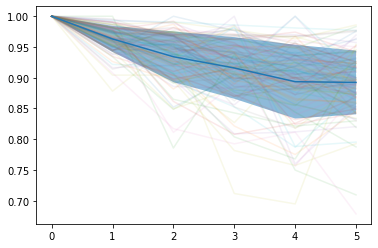

In [31]:
corr_mean = corr_imgs.mean(axis=0)
corr_std = corr_imgs.std(axis=0)

plt.plot(corr_imgs.T, alpha=0.1);
plt.plot(corr_mean);
plt.fill_between(range(6), 
                 corr_mean - corr_std, 
                 corr_mean + corr_std, alpha=0.5)

In [32]:
np.save("{}_rbf".format(corruption_name),
       corr_imgs
       )

## Results

In [33]:
corrs_rbf = np.load("{}_rbf.npy".format(corruption_name))
corrs_linear = np.load("{}_linear.npy".format(corruption_name))
corrs_resnet = np.load("{}_resnet.npy".format(corruption_name))

In [34]:
mean_rbf = corrs_rbf.mean(axis=0)
std_rbf = corrs_rbf.std(axis=0)

mean_linear = corrs_linear.mean(axis=0)
std_linear = corrs_linear.std(axis=0)

mean_resnet = corrs_resnet.mean(axis=0)
std_resnet = corrs_resnet.std(axis=0)

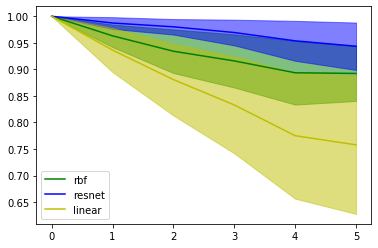

In [35]:
plt.plot(mean_rbf, color="g", label="rbf")
plt.fill_between(np.arange(mean_rbf.shape[0]), mean_rbf-std_rbf, mean_rbf+std_rbf, alpha=0.5, color="g")

plt.plot(mean_resnet, color="b", label="resnet")
plt.fill_between(np.arange(mean_resnet.shape[0]), mean_resnet-std_resnet, mean_resnet+std_resnet, alpha=0.5, color="b")

plt.plot(mean_linear, color="y", label="linear")
plt.fill_between(np.arange(mean_linear.shape[0]), mean_linear-std_linear, mean_linear+std_linear, alpha=0.5, color="y")

plt.legend()